---

## 1. OVERVIEW & METHODOLOGY

### 1.1 Purpose

This notebook corrects tree positions using an optimized **CHM-based snap-to-peak approach** (Height-Weighted Distance) and updates tree heights from CHM values for Berlin, Hamburg, and Rostock.

Key Features:
*   **Dynamic Search Radius**: Calculated individually per city based on pre-validation statistics (p75 of offsets).
*   **Smart Snapping**: Uses height-weighted distance to prefer taller trees (likely true positives) over small artifacts.
*   **Edge-Filtering**: Exports an additional dataset containing only trees isolated from other genera (20m buffer) for clean training data.

### 1.2 Workflow

```
[PHASE 1: DATA LOADING]
├── Load tree cadastre
└── Load city-specific CHM and align CRS
↓
[PHASE 2: PRE-VALIDATION]
├── Stratified sampling (Dynamic Genera Selection)
├── CHM metrics at original positions
└── Calculate Dynamic Search Radius (p75)
↓
[PHASE 3: SNAP-TO-PEAK + HEIGHTS]
├── Snap tree positions (Height-Weighted Distance)
└── Extract corrected heights from CHM
↓
[PHASE 4: FILTER + POST-VALIDATION]
├── Plausibility filtering (Height/Success)
└── Statistics and genus summaries
↓
[PHASE 5: VISUALIZATION]
├── Pre-correction diagnostics (Scatter/Hist)
└── Post-correction diagnostics (Snap Dist/Heights)
↓
[PHASE 6: EXPORT]
├── Dataset 1: Standard Corrected Trees
├── Dataset 2: Edge-Filtered Trees (20m Isolation)
└── Metadata & Summary Stats
```

### 1.3 Expected Outputs

| Category | File | Description |
| :--- | :--- | :--- |
| **Metadata** | `metadata/stats_before_<CITY>.json` | Pre-validation stats & dynamic radius |
| | `metadata/stats_after_<CITY>.json` | Final processing statistics |
| | `metadata/summary_all_cities.csv` | Cross-city summary table |
| **Plots** | `validation/validation_before_<CITY>.png` | Pre-correction diagnostics |
| | `plots/validation_after_<CITY>.png` | Post-correction results |
| **Data** | `data/trees_corrected_<CITY>.gpkg` | **Standard Dataset**: All corrected trees |
| | `data/trees_corrected_edge_filtered_20m_<CITY>.gpkg` | **Clean Dataset**: Isolated trees (no genus conflict in 20m) |
| | `data/trees_excluded_<CITY>.gpkg` | Trees failing validation/snapping |

---

## 2. SETUP & IMPORTS

### 2.1 Packages & Environment

In [2]:
!pip install geopandas rasterio matplotlib seaborn tqdm scipy --quiet

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.windows import from_bounds
from scipy.ndimage import maximum_filter
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from shapely.geometry import Point
import json
import warnings
warnings.filterwarnings('ignore')

print("✓ Imports successful")

✓ Imports successful


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2.2 Visualization & Utility Functions

In [5]:
# Publication Style Configuration
PUBLICATION_STYLE = {
    'style': 'seaborn-v0_8-whitegrid',
    'figsize': (12, 7),
    'dpi_export': 300,
}

def setup_publication_style():
    plt.rcdefaults()
    plt.style.use(PUBLICATION_STYLE['style'])
    sns.set_palette('Set2')
    plt.rcParams['figure.figsize'] = PUBLICATION_STYLE['figsize']
    plt.rcParams['savefig.dpi'] = PUBLICATION_STYLE['dpi_export']
    print("✓ Publication Style konfiguriert")

setup_publication_style()

✓ Publication Style konfiguriert


In [6]:
# Utility Functions
def log_step(step_num, phase_name, description=""):
    print(f"\n{'='*80}")
    print(f"[{step_num}] {phase_name}")
    if description:
        print(f"{description}")
    print(f"{'='*80}")

def log_success(message):
    print(f"✓ {message}")

def log_warning(message):
    print(f"⚠️  {message}")

def log_error(message):
    print(f"✗ {message}")

print("✓ Utility functions defined")

✓ Utility functions defined


---

## 3. CONFIGURATION & PARAMETERS

### 3.1 Paths

In [7]:
# Base path configuration for Google Colab
BASE_DIR = Path("/content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit")

# Input paths
INPUT_PATHS = {
    'cadastre': BASE_DIR / 'data/01_raw/tree_cadastres/processed/trees_filtered_viable.gpkg',
    'boundaries': BASE_DIR / 'data/01_raw/boundaries/city_boundaries.gpkg',
    'chm': {
        'Berlin': BASE_DIR / 'data/01_raw/CHM/processed/CHM_1m_Berlin.tif',
        'Hamburg': BASE_DIR / 'data/01_raw/CHM/processed/CHM_1m_Hamburg.tif',
        'Rostock': BASE_DIR / 'data/01_raw/CHM/processed/CHM_1m_Rostock.tif',
    },
}

# Output paths
_processed_base = BASE_DIR / 'data/02_pipeline/01_corrected'
OUTPUT_PATHS = {
    'base': _processed_base,
    'data': _processed_base / 'data',
    'plots': _processed_base / 'plots',
    'metadata': _processed_base / 'metadata',
}

# Create output directories
for key, path in OUTPUT_PATHS.items():
    if key != 'base':
        path.mkdir(parents=True, exist_ok=True)

print("✓ Paths configured")
print(f"  Base: {BASE_DIR}")
print(f"  Processed base: {OUTPUT_PATHS['base']}")
print(f"    - Data: {OUTPUT_PATHS['data']}")
print(f"    - Plots: {OUTPUT_PATHS['plots']}")
print(f"    - Metadata: {OUTPUT_PATHS['metadata']}")

✓ Paths configured
  Base: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit
  Processed base: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/01_corrected
    - Data: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/01_corrected/data
    - Plots: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/01_corrected/plots
    - Metadata: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/01_corrected/metadata


### 3.2 Processing Parameters

In [8]:
# Cities to process
CITIES = ['Berlin', 'Hamburg', 'Rostock']

# Processing parameters
PROCESSING_PARAMS = {
    # Snap-to-peak parameters
    'search_radius_m': 3,           # Initial search radius for validation (Dynamic radius is calculated from p75)
    'min_peak_height_m': 3,         # Minimum CHM height (DIN 18916)
    'footprint_size': 5,            # Local maximum

    # Height extraction
    'height_buffer_m': 1,           # Buffer for robust extraction
    'height_method': 'max',         # Max within buffer

    # Plausibility filter
    'min_tree_height_m': 3,
    'max_tree_height_m': 50,

    # Validation
    'validation_sample_size': 5000,  # Sample size for pre-validation
    'random_seed': 42,
}

# Display parameters
print("✓ Parameters loaded")
print(f"  Cities: {', '.join(CITIES)}")
print(f"  Snap radius (initial): {PROCESSING_PARAMS['search_radius_m']}m (will be optimized dynamically)")
print(f"  Min height: {PROCESSING_PARAMS['min_peak_height_m']}m")
print(f"  Height range: {PROCESSING_PARAMS['min_tree_height_m']}-{PROCESSING_PARAMS['max_tree_height_m']}m")

✓ Parameters loaded
  Cities: Berlin, Hamburg, Rostock
  Snap radius (initial): 3m (will be optimized dynamically)
  Min height: 3m
  Height range: 3-50m


---

## 4. DATA LOADING

### 4.1 Load Input Datasets

In [9]:
# Data loading happens inside process_city() per city to keep CRS handling local
# This ensures that CHM and tree cadastre are properly aligned for each city
pass

### 4.2 Data Validation

In [27]:
# Validation checks are performed during pre- and post-validation phases in process_city()
# This includes CHM data availability, spatial offset validation, and height comparisons
pass

---

## 5. MAIN PROCESSING

### 5.1 Core Processing Functions

In [10]:
def stratified_sample(trees_gdf, n=5000, genera_list=None, seed=42):
    """
    Create a stratified sample by genus and space.
    Robust version without height quartiles (height_m removed).
    Dynamically selects top genera if no list provided.

    Parameters:
    -----------
    trees_gdf : GeoDataFrame
        Tree cadastre data
    n : int
        Target sample size
    genera_list : list
        List of genera to stratify by. If None, top 15 are used.
    seed : int
        Random seed for reproducibility

    Returns:
    --------
    GeoDataFrame : Stratified sample
    """
    np.random.seed(seed)

    # Dynamic genera selection if not provided
    if genera_list is None:
        # Select top 15 genera by count
        genera_list = trees_gdf['genus_latin'].value_counts().nlargest(15).index.tolist()

    # Genus stratification
    trees_sample = trees_gdf.copy()
    trees_sample['genus_stratify'] = trees_sample['genus_latin'].apply(
        lambda x: x if x in genera_list else 'OTHER'
    )

    # Spatial grid (4x4)
    minx, miny, maxx, maxy = trees_sample.total_bounds

    try:
        grid_x = pd.cut(trees_sample.geometry.x, bins=4, labels=['X1', 'X2', 'X3', 'X4'])
        grid_y = pd.cut(trees_sample.geometry.y, bins=4, labels=['Y1', 'Y2', 'Y3', 'Y4'])
        trees_sample['spatial_grid'] = grid_x.astype(str) + '_' + grid_y.astype(str)
    except Exception:
        # Fallback: no spatial stratification
        trees_sample['spatial_grid'] = 'GRID_1'

    # Combined strata (genus + space only)
    trees_sample['stratum'] = (
        trees_sample['genus_stratify'].astype(str) + '_' +
        trees_sample['spatial_grid'].astype(str)
    )

    # Stratified sampling with robust sizing
    def safe_sample(group, target_size, total_size):
        """Sample with protection for small groups."""
        group_target = max(1, int(target_size * len(group) / total_size))
        actual_n = min(len(group), group_target)
        return group.sample(n=actual_n, random_state=seed)

    try:
        # Proportional sampling per stratum
        total_size = len(trees_sample)
        sampled = trees_sample.groupby('stratum', group_keys=False).apply(
            lambda x: safe_sample(x, n, total_size)
        )

        # If too few samples: top up with random
        if len(sampled) < n:
            remaining_trees = trees_sample[~trees_sample.index.isin(sampled.index)]
            additional_n = min(n - len(sampled), len(remaining_trees))
            if additional_n > 0:
                additional = remaining_trees.sample(n=additional_n, random_state=seed)
                sampled = pd.concat([sampled, additional])

        # If too many samples: random downsample
        if len(sampled) > n:
            sampled = sampled.sample(n=n, random_state=seed)

        return sampled

    except Exception as e:
        # Fallback: simple random sample
        print(f"  ⚠️  Stratification failed, using random sample: {str(e)}")
        actual_n = min(n, len(trees_sample))
        return trees_sample.sample(n=actual_n, random_state=seed)


def extract_chm_metrics_validation(point_geom, chm_src, buffer_m=5):
    """
    Extract CHM metrics for validation (original position).
    Simplified version for pre-validation only.

    Note: This is used only for the small sample (5k trees), so strict optimization is less critical here.
    """
    x, y = point_geom.x, point_geom.y

    window = from_bounds(
        x - buffer_m, y - buffer_m,
        x + buffer_m, y + buffer_m,
        chm_src.transform
    )

    try:
        # Read CHM data
        chm_data = chm_src.read(1, window=window, boundless=True, fill_value=chm_src.nodata)

        # Mask NoData
        nodata_value = chm_src.nodata
        if nodata_value is not None:
            chm_data = np.where(chm_data == nodata_value, np.nan, chm_data)
        chm_data = np.where(chm_data < 0, np.nan, chm_data)

        # CHM value at point
        row, col = chm_src.index(x, y)
        row_in_window = int(row - window.row_off)
        col_in_window = int(col - window.col_off)

        if 0 <= row_in_window < chm_data.shape[0] and 0 <= col_in_window < chm_data.shape[1]:
            chm_at_point = chm_data[row_in_window, col_in_window]
        else:
            chm_at_point = np.nan

        # Find local maxima
        footprint = np.ones((3, 3))
        valid_mask = ~np.isnan(chm_data)

        if np.any(valid_mask):
            chm_temp = np.where(valid_mask, chm_data, -np.inf)
            local_max = maximum_filter(chm_temp, footprint=footprint)
            is_peak = (chm_data == local_max) & valid_mask & (chm_data > 0)

            if np.any(is_peak):
                peak_rows, peak_cols = np.where(is_peak)
                peak_coords = np.column_stack([peak_rows, peak_cols])
                center = np.array([row_in_window, col_in_window])
                distances_px = np.linalg.norm(peak_coords - center, axis=1)
                distances_m = distances_px * chm_src.res[0]

                nearest_idx = np.argmin(distances_m)
                distance_to_max_m = distances_m[nearest_idx]
                chm_max_nearby = chm_data[peak_rows[nearest_idx], peak_cols[nearest_idx]]
            else:
                distance_to_max_m = np.nan
                chm_max_nearby = np.nan
        else:
            distance_to_max_m = np.nan
            chm_max_nearby = np.nan

        chm_max_buffer = np.nanmax(chm_data) if np.any(valid_mask) else np.nan

        return {
            'chm_at_point': float(chm_at_point) if not np.isnan(chm_at_point) else np.nan,
            'chm_max_5m': float(chm_max_buffer) if not np.isnan(chm_max_buffer) else np.nan,
            'distance_to_chm_max': float(distance_to_max_m) if not np.isnan(distance_to_max_m) else np.nan,
            'chm_at_nearest_peak': float(chm_max_nearby) if not np.isnan(chm_max_nearby) else np.nan,
            'local_peak_exists': not np.isnan(distance_to_max_m)
        }

    except Exception:
        return {
            'chm_at_point': np.nan,
            'chm_max_5m': np.nan,
            'distance_to_chm_max': np.nan,
            'chm_at_nearest_peak': np.nan,
            'local_peak_exists': False
        }


def get_window_from_array(chm_array, transform, x, y, radius_m):
    """
    Efficiently slice a window from the numpy array.
    Replicates rasterio.read(boundless=True) logic in memory.
    CORRECTED 2: Unpack (col, row) correctly from ~transform * (x,y).
    """
    # 1. Coordinate to Pixel
    # Note: ~transform is the inverse transform (coords -> pixels)
    # It returns (col, row) == (x_pixel, y_pixel)
    col_float, row_float = ~transform * (x, y)
    row, col = int(row_float), int(col_float)

    # 2. Radius to Pixel (assuming square pixels roughly)
    res = transform[0]
    radius_px = int(np.ceil(abs(radius_m / res)))

    # 3. Define bounds
    r_start = row - radius_px
    r_end = row + radius_px + 1
    c_start = col - radius_px
    c_end = col + radius_px + 1

    h, w = chm_array.shape

    # 4. Handle edges (padding)
    # Calculate intersection with image
    r_s_valid = max(0, r_start)
    r_e_valid = min(h, r_end)
    c_s_valid = max(0, c_start)
    c_e_valid = min(w, c_end)

    # Check if empty
    if r_s_valid >= r_e_valid or c_s_valid >= c_e_valid:
        return np.full((2*radius_px+1, 2*radius_px+1), np.nan), 0, 0

    # Extract valid chunk
    data_chunk = chm_array[r_s_valid:r_e_valid, c_s_valid:c_e_valid]

    # If full window is valid, return it directly
    if (r_start == r_s_valid) and (r_end == r_e_valid) and (c_start == c_s_valid) and (c_end == c_e_valid):
        return data_chunk, r_start, c_start

    # Else pad with NaNs
    out_h = r_end - r_start
    out_w = c_end - c_start
    padded = np.full((out_h, out_w), np.nan, dtype=chm_array.dtype)

    pad_r = r_s_valid - r_start
    pad_c = c_s_valid - c_start

    padded[pad_r : pad_r + data_chunk.shape[0],
           pad_c : pad_c + data_chunk.shape[1]] = data_chunk

    return padded, r_start, c_start


def snap_to_peak(tree_point, chm_src=None, chm_array=None, transform=None, search_radius_m=5, min_height_m=3, footprint_size=3):
    """
    Optimized Snap-to-peak algorithm.
    Supports both disk-based (chm_src) and memory-based (chm_array) execution.
    """
    x, y = tree_point.x, tree_point.y

    # --- PATH A: MEMORY BASED (FAST) ---
    if chm_array is not None and transform is not None:
        try:
            chm_data, r_start, c_start = get_window_from_array(chm_array, transform, x, y, search_radius_m)

            # Center in the window (relative to r_start, c_start)
            # We recalculate the exact pixel of the tree using the same int() logic
            # CORRECTED: Unpack (col, row)
            col_float, row_float = ~transform * (x, y)

            # Global indices
            row_global, col_global = int(row_float), int(col_float)

            row_in_window = row_global - r_start
            col_in_window = col_global - c_start

            # Safety check for bounds inside window
            if not (0 <= int(row_in_window) < chm_data.shape[0] and 0 <= int(col_in_window) < chm_data.shape[1]):
                chm_at_original = np.nan
            else:
                chm_at_original = chm_data[int(row_in_window), int(col_in_window)]

            pixel_size = transform[0]

        except Exception:
            return {'snap_success': False, 'corrected_geometry': None, 'snap_distance_m': np.nan, 'peak_height_m': np.nan, 'chm_at_original': np.nan}

    # --- PATH B: DISK BASED (SLOW) ---
    else:
        window = from_bounds(
            x - search_radius_m, y - search_radius_m,
            x + search_radius_m, y + search_radius_m,
            chm_src.transform
        )
        try:
            chm_data = chm_src.read(1, window=window, boundless=True, fill_value=chm_src.nodata)
            if chm_src.nodata is not None:
                chm_data = np.where(chm_data == chm_src.nodata, np.nan, chm_data)
            chm_data = np.where(chm_data < 0, np.nan, chm_data)

            row_orig, col_orig = chm_src.index(x, y)
            row_in_window = int(row_orig - window.row_off)
            col_in_window = int(col_orig - window.col_off)

            if (0 <= row_in_window < chm_data.shape[0] and 0 <= col_in_window < chm_data.shape[1]):
                chm_at_original = chm_data[row_in_window, col_in_window]
            else:
                chm_at_original = np.nan

            pixel_size = chm_src.res[0]
            r_start = window.row_off # approximate for reconstructing global coord
            c_start = window.col_off
            transform = chm_src.transform

        except Exception:
            return {'snap_success': False, 'corrected_geometry': None, 'snap_distance_m': np.nan, 'peak_height_m': np.nan, 'chm_at_original': np.nan}

    # --- COMMON LOGIC ---
    try:
        # Find local maxima
        footprint = np.ones((footprint_size, footprint_size))
        valid_mask = ~np.isnan(chm_data)

        if not np.any(valid_mask):
            return {
                'snap_success': False, 'corrected_geometry': None,
                'snap_distance_m': np.nan, 'peak_height_m': np.nan, 'chm_at_original': chm_at_original
            }

        chm_temp = np.where(valid_mask, chm_data, -np.inf)
        local_max = maximum_filter(chm_temp, footprint=footprint)
        is_peak = (chm_data == local_max) & valid_mask & (chm_data >= min_height_m)

        if not np.any(is_peak):
            return {
                'snap_success': False, 'corrected_geometry': None,
                'snap_distance_m': np.nan, 'peak_height_m': np.nan, 'chm_at_original': chm_at_original
            }

        # Find nearest peak
        peak_rows, peak_cols = np.where(is_peak)
        peak_coords = np.column_stack([peak_rows, peak_cols])
        center = np.array([row_in_window, col_in_window])

        # Distances in pixels
        distances_px = np.linalg.norm(peak_coords - center, axis=1)
        distances_m = distances_px * pixel_size

        # Filter: peaks within search_radius_m
        valid_peaks_mask = distances_m <= search_radius_m
        if not np.any(valid_peaks_mask):
            return {
                'snap_success': False, 'corrected_geometry': None,
                'snap_distance_m': np.nan, 'peak_height_m': np.nan, 'chm_at_original': chm_at_original
            }

        valid_distances = distances_m[valid_peaks_mask]
        valid_peak_coords = peak_coords[valid_peaks_mask]

        # Extract heights
        valid_peak_rows = valid_peak_coords[:, 0]
        valid_peak_cols = valid_peak_coords[:, 1]
        valid_peak_heights = chm_data[valid_peak_rows, valid_peak_cols]

        # OPTIMIZATION: Height-Weighted Distance
        scores = valid_distances / (valid_peak_heights + 1)
        best_idx = np.argmin(scores)

        peak_row_local = valid_peak_coords[best_idx, 0]
        peak_col_local = valid_peak_coords[best_idx, 1]
        peak_height = valid_peak_heights[best_idx]
        snap_distance = valid_distances[best_idx]

        # Compute new geometry
        # We need global coordinates.
        # If memory based: global_row = r_start + local_row
        # If disk based: r_start was window.row_off

        global_peak_row = r_start + peak_row_local
        global_peak_col = c_start + peak_col_local

        peak_x, peak_y = rasterio.transform.xy(
            transform,
            global_peak_row,
            global_peak_col,
            offset='center'
        )

        corrected_geom = Point(peak_x, peak_y)

        return {
            'snap_success': True,
            'corrected_geometry': corrected_geom,
            'snap_distance_m': float(snap_distance),
            'peak_height_m': float(peak_height),
            'chm_at_original': float(chm_at_original) if not np.isnan(chm_at_original) else np.nan
        }

    except Exception:
        return {
            'snap_success': False, 'corrected_geometry': None,
            'snap_distance_m': np.nan, 'peak_height_m': np.nan, 'chm_at_original': np.nan
        }


def extract_height_from_chm(corrected_point, chm_src=None, chm_array=None, transform=None, buffer_m=1, method='max'):
    """
    Extract final tree height from the CHM (supports Memory or Disk).
    """
    x, y = corrected_point.x, corrected_point.y

    # --- PATH A: MEMORY ---
    if chm_array is not None and transform is not None:
        try:
            chm_data, _, _ = get_window_from_array(chm_array, transform, x, y, buffer_m)
        except Exception:
            return np.nan

    # --- PATH B: DISK ---
    else:
        window = from_bounds(
            x - buffer_m, y - buffer_m,
            x + buffer_m, y + buffer_m,
            chm_src.transform
        )
        try:
            chm_data = chm_src.read(1, window=window, boundless=True, fill_value=chm_src.nodata)
            if chm_src.nodata is not None:
                chm_data = np.where(chm_data == chm_src.nodata, np.nan, chm_data)
            chm_data = np.where(chm_data < 0, np.nan, chm_data)
        except Exception:
            return np.nan

    # --- AGGREGATION ---
    if method == 'max':
        return float(np.nanmax(chm_data))
    if method == 'mean':
        return float(np.nanmean(chm_data))
    if method == 'p90':
        return float(np.nanpercentile(chm_data, 90))
    return np.nan

print("✓ Core processing functions optimized for Memory/NumPy (Logic corrected to match Rasterio)")

✓ Core processing functions optimized for Memory/NumPy (Logic corrected to match Rasterio)


### 5.2 City Processing Pipeline

In [11]:
def process_city(city_name):
    """
    Full workflow for a single city.
    Optimized with Tiled Processing to save RAM.
    """
    print(f"\n{'='*80}")
    print(f"PROCESSING: {city_name}")
    print(f"{'='*80}")

    # ========================================================================
    # PHASE 1: DATA LOADING
    # ========================================================================

    print("\n--- PHASE 1: DATA LOADING ---")

    # Load tree cadastre
    trees_all = gpd.read_file(INPUT_PATHS['cadastre'])
    trees_city = trees_all[trees_all['city'] == city_name].copy()
    print(f"✓ Tree cadastre: {len(trees_city):,} trees")

    # Dataset description
    print("  Dataset Overview:")
    print(f"  - CRS: {trees_city.crs}")
    cols_to_show = [c for c in trees_city.columns if c in ['tree_id', 'genus_latin', 'species_latin', 'height_m', 'plant_year', 'crown_width_m']]
    print(f"  - Key Columns: {cols_to_show}")
    if 'height_m' in trees_city.columns:
        h_stats = trees_city['height_m'].describe()
        print(f"  - Height Stats: Mean={h_stats['mean']:.1f}m, Min={h_stats['min']:.1f}m, Max={h_stats['max']:.1f}m")

    # Load CHM Metadata
    chm_path = INPUT_PATHS['chm'][city_name]
    with rasterio.open(chm_path) as src:
        chm_crs = src.crs
        chm_profile = src.profile
        print(f"✓ CHM Metadata loaded: {chm_path.name}")
        print(f"  - CRS: {chm_crs}")
        print(f"  - Shape: {src.shape}")

    # CRS check
    if trees_city.crs != chm_crs:
        print(f"⚠️  Reproject trees: {trees_city.crs} -> {chm_crs}")
        trees_city = trees_city.to_crs(chm_crs)

    # ========================================================================
    # PHASE 2: PRE-VALIDATION
    # ========================================================================

    print("\n--- PHASE 2: PRE-VALIDATION ---")

    # Create sample (with fallback for small cities)
    sample_size = min(PROCESSING_PARAMS['validation_sample_size'], len(trees_city))
    if len(trees_city) < 1000:
        sample_size = min(500, len(trees_city))
        print(f"  ⚠️  Small city, reduce sample to {sample_size}")

    sample_trees = stratified_sample(
        trees_city,
        n=sample_size,
        seed=PROCESSING_PARAMS['random_seed']
    )
    print(f"✓ Sample created: {len(sample_trees):,} trees")

    # Extract CHM metrics (Using original disk access for sample is fine)
    print("Extracting CHM metrics (original positions)...")
    chm_metrics_list = []

    with rasterio.open(chm_path) as chm_src:
        for idx, row in tqdm(sample_trees.iterrows(), total=len(sample_trees), desc="CHM extraction"):
            metrics = extract_chm_metrics_validation(
                row.geometry,
                chm_src,
                buffer_m=PROCESSING_PARAMS['search_radius_m']
            )
            metrics['tree_id'] = row['tree_id']
            chm_metrics_list.append(metrics)

    chm_metrics_df = pd.DataFrame(chm_metrics_list)
    sample_trees = sample_trees.merge(chm_metrics_df, on='tree_id', how='left')

    # Compute statistics
    valid_data = sample_trees[
        sample_trees['chm_at_point'].notna()
    ].copy()

    print(f"\n✓ Validation finished: {len(valid_data):,} / {len(sample_trees):,} with CHM data")

    # DYNAMIC SEARCH RADIUS CALCULATION
    dist_values = valid_data['distance_to_chm_max'].dropna()
    if len(dist_values) > 10:
        p75 = dist_values.quantile(0.75)
        dynamic_radius = float(np.ceil(p75))
    else:
        p75 = np.nan
        dynamic_radius = PROCESSING_PARAMS['search_radius_m']
        print("  ⚠️  Not enough data for dynamic radius, using default.")

    stats_before = {
        'city': city_name,
        'n_trees_total': len(trees_city),
        'n_trees_sampled': len(sample_trees),
        'n_trees_valid_chm': len(valid_data),
        'pct_chm_valid': len(valid_data) / len(sample_trees) * 100,
        'pct_local_peak_exists': sample_trees['local_peak_exists'].mean() * 100,
        'median_distance_to_peak': valid_data['distance_to_chm_max'].median(),
        'mean_distance_to_peak': valid_data['distance_to_chm_max'].mean(),
        'p75_distance_to_peak': p75,
        'dynamic_search_radius_m': dynamic_radius,
    }

    # Correlation (if cadastre height exists)
    if 'height_m' in valid_data.columns and valid_data['height_m'].notna().sum() > 100:
        height_valid = valid_data[valid_data['height_m'].notna()].copy()
        r, p = pearsonr(height_valid['chm_at_point'], height_valid['height_m'])
        stats_before['pearson_r'] = r
        print(f"  - Correlation (cadastre vs. CHM): r={r:.3f}")

    print(f"  - Dynamic Search Radius set to: {stats_before['dynamic_search_radius_m']}m")

    # Save Stats Before
    stats_path = OUTPUT_PATHS['metadata'] / f'stats_before_{city_name}.json'
    with open(stats_path, 'w') as f:
        json.dump(stats_before, f, indent=2)

    # ========================================================================
    # PHASE 3: SNAP-TO-PEAK & HEIGHT CORRECTION (TILED OPTIMIZATION)
    # ========================================================================

    print("\n--- PHASE 3: SNAP-TO-PEAK & HEIGHT CORRECTION ---")
    print(f"Processing {len(trees_city):,} trees using Tiled Processing...")

    # Configuration for tiling
    CHUNK_SIZE = 4096  # 4k x 4k pixels (approx 16-60MB per chunk depending on dtype)
    PADDING_M = dynamic_radius + 2  # Padding to ensure we find peaks at the edge

    results = []

    with rasterio.open(chm_path) as src:
        # Calculate padding in pixels
        res = src.res[0]
        padding_px = int(np.ceil(PADDING_M / res))

        width = src.width
        height = src.height

        # Prepare spatial index for fast querying
        _ = trees_city.sindex

        # Progress tracking
        # We iterate tiles, but we want to show tree progress
        pbar = tqdm(total=len(trees_city), desc=f"Processing {city_name}")

        # Loop through tiles
        for col_off in range(0, width, CHUNK_SIZE):
            for row_off in range(0, height, CHUNK_SIZE):

                # 1. Define the CORE window (the area we are responsible for)
                window_core = rasterio.windows.Window(col_off, row_off, CHUNK_SIZE, CHUNK_SIZE)
                # Clip to image bounds
                window_core = window_core.intersection(rasterio.windows.Window(0, 0, width, height))

                # 2. Find trees in this core tile
                # Get spatial bounds of the window
                core_bounds = src.window_bounds(window_core)

                # Query trees (cx handles [minx:maxx, miny:maxy])
                # Add a tiny epsilon buffer to bounds to catch trees exactly on the edge
                eps = 1e-5
                trees_in_tile = trees_city.cx[core_bounds[0]-eps:core_bounds[2]+eps, core_bounds[1]-eps:core_bounds[3]+eps]

                if trees_in_tile.empty:
                    continue

                # 3. Define the READ window (with PADDING for context)
                # We read a bit larger to handle trees exactly on the edge
                window_read = rasterio.windows.Window(
                    col_off - padding_px,
                    row_off - padding_px,
                    CHUNK_SIZE + 2*padding_px,
                    CHUNK_SIZE + 2*padding_px
                )

                # 4. Read Data (Boundless handles out-of-bounds padding automatically)
                chm_chunk = src.read(1, window=window_read, boundless=True, fill_value=np.nan)
                if src.nodata is not None:
                    chm_chunk = np.where(chm_chunk == src.nodata, np.nan, chm_chunk)
                chm_chunk = np.where(chm_chunk < 0, np.nan, chm_chunk)

                # Ensure float32 for calculations
                chm_chunk = chm_chunk.astype('float32')

                # Get transform for the buffered chunk to map back to global coords
                chunk_transform = src.window_transform(window_read)

                # 5. Process trees in this batch
                tile_results = []
                for idx, tree in trees_in_tile.iterrows():
                    snap_result = snap_to_peak(
                        tree.geometry,
                        chm_array=chm_chunk,
                        transform=chunk_transform,
                        search_radius_m=dynamic_radius,
                        min_height_m=PROCESSING_PARAMS['min_peak_height_m'],
                        footprint_size=PROCESSING_PARAMS['footprint_size']
                    )

                    if snap_result['snap_success']:
                        height_chm = extract_height_from_chm(
                            snap_result['corrected_geometry'],
                            chm_array=chm_chunk,
                            transform=chunk_transform,
                            buffer_m=PROCESSING_PARAMS['height_buffer_m'],
                            method=PROCESSING_PARAMS['height_method']
                        )

                        height_plausible = (
                            not np.isnan(height_chm) and
                            PROCESSING_PARAMS['min_tree_height_m'] <= height_chm <= PROCESSING_PARAMS['max_tree_height_m']
                        )

                        tile_results.append({
                            'tree_id': tree['tree_id'],
                            'tree_type': tree.get('tree_type', None),
                            'genus_latin': tree['genus_latin'],
                            'species_latin': tree['species_latin'],
                            'plant_year': tree['plant_year'],
                            'city': tree['city'],
                            'original_x': tree.geometry.x,
                            'original_y': tree.geometry.y,
                            'geometry': snap_result['corrected_geometry'],
                            'height_m': height_chm,
                            'snap_success': True,
                            'snap_distance_m': snap_result['snap_distance_m'],
                            'height_plausible': height_plausible,
                            'chm_at_original': snap_result['chm_at_original'],
                            'chm_at_corrected': height_chm,
                        })

                results.extend(tile_results)
                pbar.update(len(trees_in_tile))

        pbar.close()

    # Convert to GeoDataFrame
    trees_corrected = gpd.GeoDataFrame(results, crs=trees_city.crs)

    # Remove potential duplicates (trees on tile edges might be processed twice if bounds overlap slightly)
    trees_corrected = trees_corrected.drop_duplicates(subset='tree_id')

    print("\n✓ Snap-to-peak finished")
    print(f"  - Snap success: {len(trees_corrected):,} / {len(trees_city):,} ({len(trees_corrected)/len(trees_city)*100:.1f}%)")

    # ========================================================================
    # PHASE 4: FILTER & POST-VALIDATION
    # ========================================================================

    print("\n--- PHASE 4: FILTER & POST-VALIDATION ---")

    # Apply filter
    trees_final = trees_corrected[
        trees_corrected['snap_success'] &
        trees_corrected['height_plausible']
    ].copy()

    print("✓ Filter applied")
    print(f"  - Retained: {len(trees_final):,} / {len(trees_city):,} ({len(trees_final)/len(trees_city)*100:.1f}%)")

    # Post statistics
    stats_after = {
        'city': city_name,
        'n_trees_original': len(trees_city),
        'n_trees_after_snap': len(trees_corrected),
        'n_trees_final': len(trees_final),
        'pct_retained': len(trees_final) / len(trees_city) * 100,
        'median_snap_distance': trees_final['snap_distance_m'].median(),
        'mean_snap_distance': trees_final['snap_distance_m'].mean(),
        'pct_snap_lt_1m': (trees_final['snap_distance_m'] < 1).mean() * 100,
        'pct_snap_lt_2m': (trees_final['snap_distance_m'] < 2).mean() * 100,
        'height_min': trees_final['height_m'].min(),
        'height_max': trees_final['height_m'].max(),
        'height_mean': trees_final['height_m'].mean(),
        'height_median': trees_final['height_m'].median(),
        'height_std': trees_final['height_m'].std(),
        'n_genera': trees_final['genus_latin'].nunique(),
        'dynamic_search_radius_m': dynamic_radius,
    }

    # Genus statistics
    genus_stats = trees_final.groupby('genus_latin').agg({
        'tree_id': 'count',
        'height_m': ['mean', 'std', 'min', 'max']
    }).round(2)
    genus_stats.columns = ['count', 'height_mean', 'height_std', 'height_min', 'height_max']
    stats_after['height_by_genus'] = genus_stats.to_dict('index')

    print(f"  - Median snap distance: {stats_after['median_snap_distance']:.2f}m")
    print(f"  - Height range: {stats_after['height_min']:.1f}-{stats_after['height_max']:.1f}m")

    # Save
    stats_path = OUTPUT_PATHS['metadata'] / f'stats_after_{city_name}.json'
    with open(stats_path, 'w') as f:
        json.dump(stats_after, f, indent=2, default=str)

    # ========================================================================
    # PHASE 5: VISUALIZATIONS
    # ========================================================================

    print("\n--- PHASE 5: VISUALIZATIONS ---")

    # Plot 1: Pre-validation
    if len(valid_data) > 0:
        has_height = 'height_m' in valid_data.columns and valid_data['height_m'].notna().sum() > 100
        n_plots = 3 if has_height else 2
        fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 6))

        if has_height:
            ax = axes[0]
            height_valid = valid_data[valid_data['height_m'].notna()]
            ax.scatter(height_valid['height_m'], height_valid['chm_at_point'],
                      alpha=0.4, s=20, edgecolors='none')
            z = np.polyfit(height_valid['height_m'], height_valid['chm_at_point'], 1)
            p = np.poly1d(z)
            x_line = np.linspace(height_valid['height_m'].min(), height_valid['height_m'].max(), 100)
            ax.plot(x_line, p(x_line), "r--", linewidth=2, label=f'y={z[0]:.2f}x+{z[1]:.2f}')
            ax.plot([0, height_valid['height_m'].max()], [0, height_valid['height_m'].max()],
                   'k-', linewidth=1, alpha=0.5, label='1:1')
            ax.set_xlabel('Cadastre height (m)')
            ax.set_ylabel('CHM height (m)')
            ax.set_title(f'{city_name}: Height comparison (pre-correction)\nr={stats_before.get("pearson_r", np.nan):.3f}')
            ax.legend()
            ax.grid(True, alpha=0.3)

            ax = axes[1]
            diffs = height_valid['chm_at_point'] - height_valid['height_m']
            ax.hist(diffs.dropna(), bins=30, color='skyblue', edgecolor='black', alpha=0.7)
            ax.axvline(0, color='black', linewidth=1)
            ax.axvline(diffs.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {diffs.median():.2f}m')
            ax.set_xlabel('Height Difference (CHM - Cadastre) [m]')
            ax.set_ylabel('Number of trees')
            ax.set_title(f'{city_name}: Height Difference Distribution')
            ax.legend()
            ax.grid(True, alpha=0.3, axis='y')
            ax = axes[2]
        else:
            axes[0].text(0.5, 0.5, 'No cadastre heights available', ha='center', va='center', transform=axes[0].transAxes)
            ax = axes[1]

        ax.hist(valid_data['distance_to_chm_max'].dropna(), bins=30, edgecolor='black', alpha=0.7)
        ax.axvline(stats_before['median_distance_to_peak'], color='red', linestyle='--', linewidth=2, label=f'Median: {stats_before["median_distance_to_peak"]:.2f}m')
        ax.axvline(dynamic_radius, color='green', linestyle='-', linewidth=2, label=f'Cutoff (p75 rounded): {dynamic_radius}m')
        ax.set_xlabel('Distance to CHM maximum (m)')
        ax.set_ylabel('Number of trees')
        ax.set_title(f'{city_name}: Spatial offset (pre-correction)')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plot_path = OUTPUT_PATHS['plots'] / f'validation_before_{city_name}.png'
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.close()

    # Plot 2: Post-correction
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    ax = axes[0]
    ax.hist(trees_final['snap_distance_m'], bins=30, edgecolor='black', alpha=0.7)
    ax.axvline(stats_after['median_snap_distance'], color='red', linestyle='--', linewidth=2, label=f'Median: {stats_after["median_snap_distance"]:.2f}m')
    ax.set_xlabel('Snap distance (m)')
    ax.set_ylabel('Number of trees')
    ax.set_title(f'{city_name}: Position correction distances')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    ax = axes[1]
    ax.hist(trees_final['height_m'], bins=40, edgecolor='black', alpha=0.7)
    ax.axvline(stats_after['height_median'], color='red', linestyle='--', linewidth=2, label=f'Median: {stats_after["height_median"]:.1f}m')
    ax.set_xlabel('CHM height (m)')
    ax.set_ylabel('Number of trees')
    ax.set_title(f'{city_name}: Final height distribution (from CHM)')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plot_path = OUTPUT_PATHS['plots'] / f'validation_after_{city_name}.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close()

    # ========================================================================
    # PHASE 6: EXPORT
    # ========================================================================

    print("\n--- PHASE 6: EXPORT ---")
    FINAL_COLUMNS = ['tree_id', 'city', 'tree_type', 'genus_latin', 'species_latin', 'height_m', 'geometry']
    trees_export = trees_final[FINAL_COLUMNS].copy()

    # 1. Standard
    output_path = OUTPUT_PATHS['data'] / f'trees_corrected_{city_name}.gpkg'
    trees_export.to_file(output_path, driver='GPKG')
    print(f"✓ Dataset 1 saved: {output_path.name}")

    # 2. Edge Filter
    print("\n  Applying Edge-Filter (Isolation 20m)...")
    trees_buffer = trees_export.copy()
    trees_buffer['geometry'] = trees_buffer.geometry.buffer(20)
    joined = gpd.sjoin(trees_buffer, trees_export, how='inner', predicate='intersects')
    conflicts = joined[joined['genus_latin_left'] != joined['genus_latin_right']]
    ids_to_remove = conflicts['tree_id_left'].unique()
    trees_isolated = trees_export[~trees_export['tree_id'].isin(ids_to_remove)].copy()

    iso_output_path = OUTPUT_PATHS['data'] / f'trees_corrected_edge_filtered_20m_{city_name}.gpkg'
    trees_isolated.to_file(iso_output_path, driver='GPKG')
    print(f"✓ Dataset 2 saved: {iso_output_path.name}")

    # Excluded
    trees_excluded = trees_city[~trees_city['tree_id'].isin(trees_final['tree_id'])].copy()
    excluded_path = OUTPUT_PATHS['data'] / f'trees_excluded_{city_name}.gpkg'
    trees_excluded.to_file(excluded_path, driver='GPKG')
    print(f"\n✓ Excluded saved: {excluded_path.name}")

    print(f"\n{'='*80}")
    print(f"✓ {city_name} COMPLETE")
    print(f"{'='*80}\n")

    return stats_before, stats_after

### 5.3 Execute Processing for All Cities

In [30]:
# Execute processing for all cities
all_stats = {}

for city in CITIES:
    try:
        stats_before, stats_after = process_city(city)
        all_stats[city] = {
            'before': stats_before,
            'after': stats_after
        }
    except Exception as e:
        print(f"\n⚠️  ERROR for {city}:")
        print(f"  {str(e)}")
        import traceback
        traceback.print_exc()
        continue


PROCESSING: Berlin

--- PHASE 1: DATA LOADING ---
✓ Tree cadastre: 861,935 trees
  Dataset Overview:
  - CRS: EPSG:25832
  - Key Columns: ['tree_id', 'genus_latin', 'species_latin', 'plant_year', 'height_m']
  - Height Stats: Mean=14.0m, Min=0.0m, Max=45.0m
✓ CHM Metadata loaded: CHM_1m_Berlin.tif
  - CRS: EPSG:25832
  - Shape: (37360, 46092)

--- PHASE 2: PRE-VALIDATION ---
✓ Sample created: 5,000 trees
Extracting CHM metrics (original positions)...


CHM extraction: 100%|██████████| 5000/5000 [01:27<00:00, 56.96it/s]



✓ Validation finished: 4,991 / 5,000 with CHM data
  - Correlation (cadastre vs. CHM): r=0.565
  - Dynamic Search Radius set to: 3.0m

--- PHASE 3: SNAP-TO-PEAK & HEIGHT CORRECTION ---
Processing 861,935 trees using Tiled Processing...


Processing Berlin: 100%|██████████| 861935/861935 [09:02<00:00, 1587.43it/s]



✓ Snap-to-peak finished
  - Snap success: 609,189 / 861,935 (70.7%)

--- PHASE 4: FILTER & POST-VALIDATION ---
✓ Filter applied
  - Retained: 609,189 / 861,935 (70.7%)
  - Median snap distance: 1.42m
  - Height range: 3.0-49.9m

--- PHASE 5: VISUALIZATIONS ---

--- PHASE 6: EXPORT ---
✓ Dataset 1 saved: trees_corrected_Berlin.gpkg

  Applying Edge-Filter (Isolation 20m)...
✓ Dataset 2 saved: trees_corrected_edge_filtered_20m_Berlin.gpkg

✓ Excluded saved: trees_excluded_Berlin.gpkg

✓ Berlin COMPLETE


PROCESSING: Hamburg

--- PHASE 1: DATA LOADING ---
✓ Tree cadastre: 215,787 trees
  Dataset Overview:
  - CRS: EPSG:25832
  - Key Columns: ['tree_id', 'genus_latin', 'species_latin', 'plant_year', 'height_m']
  - Height Stats: Mean=nanm, Min=nanm, Max=nanm
✓ CHM Metadata loaded: CHM_1m_Hamburg.tif
  - CRS: EPSG:25832
  - Shape: (39000, 40363)

--- PHASE 2: PRE-VALIDATION ---
✓ Sample created: 5,000 trees
Extracting CHM metrics (original positions)...


CHM extraction: 100%|██████████| 5000/5000 [01:12<00:00, 68.67it/s]



✓ Validation finished: 4,977 / 5,000 with CHM data
  - Dynamic Search Radius set to: 2.0m

--- PHASE 3: SNAP-TO-PEAK & HEIGHT CORRECTION ---
Processing 215,787 trees using Tiled Processing...


Processing Hamburg: 100%|██████████| 215787/215787 [02:37<00:00, 1373.54it/s]



✓ Snap-to-peak finished
  - Snap success: 112,915 / 215,787 (52.3%)

--- PHASE 4: FILTER & POST-VALIDATION ---
✓ Filter applied
  - Retained: 112,915 / 215,787 (52.3%)
  - Median snap distance: 1.00m
  - Height range: 3.0-46.6m

--- PHASE 5: VISUALIZATIONS ---

--- PHASE 6: EXPORT ---
✓ Dataset 1 saved: trees_corrected_Hamburg.gpkg

  Applying Edge-Filter (Isolation 20m)...
✓ Dataset 2 saved: trees_corrected_edge_filtered_20m_Hamburg.gpkg

✓ Excluded saved: trees_excluded_Hamburg.gpkg

✓ Hamburg COMPLETE


PROCESSING: Rostock

--- PHASE 1: DATA LOADING ---
✓ Tree cadastre: 62,319 trees
  Dataset Overview:
  - CRS: EPSG:25832
  - Key Columns: ['tree_id', 'genus_latin', 'species_latin', 'plant_year', 'height_m']
  - Height Stats: Mean=12.7m, Min=0.5m, Max=915.0m
✓ CHM Metadata loaded: CHM_1m_Rostock.tif
  - CRS: EPSG:25832
  - Shape: (22953, 19822)

--- PHASE 2: PRE-VALIDATION ---
✓ Sample created: 5,000 trees
Extracting CHM metrics (original positions)...


CHM extraction: 100%|██████████| 5000/5000 [01:22<00:00, 60.67it/s]



✓ Validation finished: 4,994 / 5,000 with CHM data
  - Correlation (cadastre vs. CHM): r=0.591
  - Dynamic Search Radius set to: 3.0m

--- PHASE 3: SNAP-TO-PEAK & HEIGHT CORRECTION ---
Processing 62,319 trees using Tiled Processing...


Processing Rostock: 100%|██████████| 62319/62319 [00:48<00:00, 1272.86it/s]



✓ Snap-to-peak finished
  - Snap success: 44,095 / 62,319 (70.8%)

--- PHASE 4: FILTER & POST-VALIDATION ---
✓ Filter applied
  - Retained: 44,095 / 62,319 (70.8%)
  - Median snap distance: 2.00m
  - Height range: 3.0-35.6m

--- PHASE 5: VISUALIZATIONS ---

--- PHASE 6: EXPORT ---
✓ Dataset 1 saved: trees_corrected_Rostock.gpkg

  Applying Edge-Filter (Isolation 20m)...
✓ Dataset 2 saved: trees_corrected_edge_filtered_20m_Rostock.gpkg

✓ Excluded saved: trees_excluded_Rostock.gpkg

✓ Rostock COMPLETE



---

## 6. RESULTS & OUTPUTS

### 6.1 Summary Statistics

In [31]:
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

summary_data = []

for city in CITIES:
    if city in all_stats:
        stats = all_stats[city]['after']
        summary_data.append({
            'City': city,
            'Original': f"{stats['n_trees_original']:,}",
            'Final': f"{stats['n_trees_final']:,}",
            'Retained %': f"{stats['pct_retained']:.1f}%",
            'Median Snap (m)': f"{stats['median_snap_distance']:.2f}",
            'Median Height (m)': f"{stats['height_median']:.1f}",
            'Genera': stats['n_genera'],
        })

summary_df = pd.DataFrame(summary_data)
print("\n")
print(summary_df.to_string(index=False))


SUMMARY STATISTICS


   City Original   Final Retained % Median Snap (m) Median Height (m)  Genera
 Berlin  861,935 609,189      70.7%            1.42              14.4      20
Hamburg  215,787 112,915      52.3%            1.00              14.0      20
Rostock   62,319  44,095      70.8%            2.00              11.4      20



FAILURE ANALYSIS (EXACT): Hamburg
Analyzing sample of 2000 trees...
Context: Dynamic Radius=2.0m, Min Peak=3m


Diagnosing: 100%|██████████| 2000/2000 [01:33<00:00, 21.48it/s]



FAILURE REASONS (Validated):
SNAP_FAIL (No Data/Peaks)     1428
PASSED (Should not happen)     572
dtype: int64


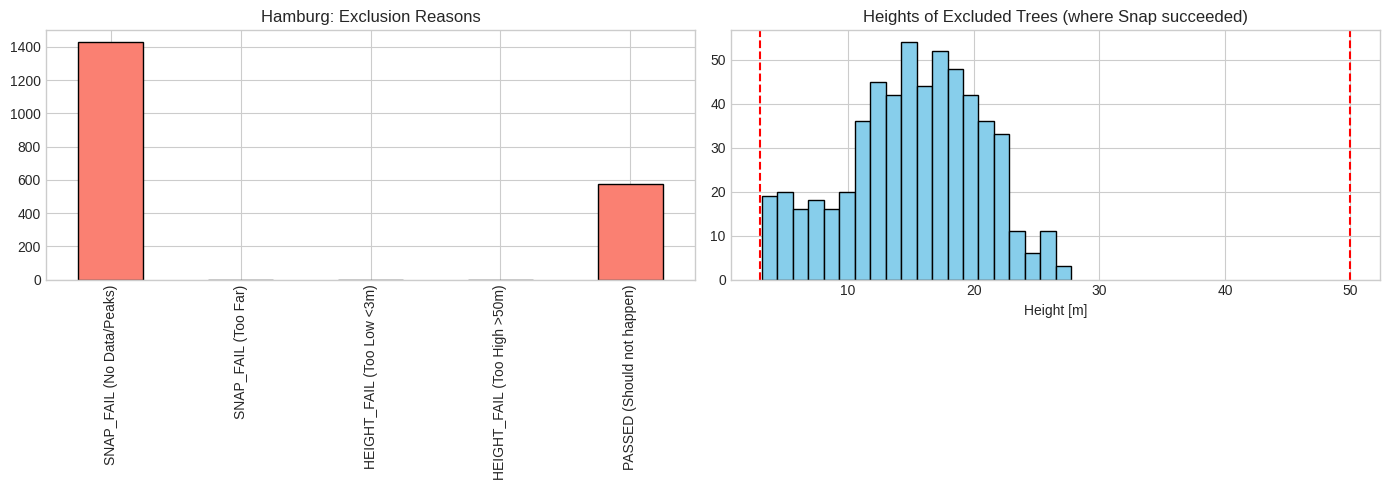

In [12]:
def analyze_failures(city_name, sample_size=1000):
    """
    Diagnose why trees were excluded using the EXACT pipeline functions.
    """
    print(f"\n{'='*80}")
    print(f"FAILURE ANALYSIS (EXACT): {city_name}")
    print(f"{'='*80}")

    # 1. Load Excluded Trees
    excluded_path = OUTPUT_PATHS['data'] / f'trees_excluded_{city_name}.gpkg'
    if not excluded_path.exists():
        print(f"❌ File not found: {excluded_path}")
        return

    trees_excluded = gpd.read_file(excluded_path)
    if len(trees_excluded) == 0:
        print("No excluded trees found.")
        return

    # Sample
    n = min(sample_size, len(trees_excluded))
    sample = trees_excluded.sample(n=n, random_state=42).copy()
    print(f"Analyzing sample of {n} trees...")

    # 2. Load Parameters
    stats_path = OUTPUT_PATHS['metadata'] / f'stats_before_{city_name}.json'
    with open(stats_path, 'r') as f:
        stats = json.load(f)

    radius = stats['dynamic_search_radius_m']
    print(f"Context: Dynamic Radius={radius}m, Min Peak={PROCESSING_PARAMS['min_peak_height_m']}m")

    # 3. Diagnostic Loop using REAL functions
    chm_path = INPUT_PATHS['chm'][city_name]

    failure_counts = {
        'SNAP_FAIL (No Data/Peaks)': 0,
        'SNAP_FAIL (Too Far)': 0,
        'HEIGHT_FAIL (Too Low <3m)': 0,
        'HEIGHT_FAIL (Too High >50m)': 0,
        'PASSED (Should not happen)': 0
    }

    snap_distances = []
    final_heights = []

    with rasterio.open(chm_path) as src:
        for idx, row in tqdm(sample.iterrows(), total=n, desc="Diagnosing"):

            # A. Try Snap
            # We use the disk-based path of snap_to_peak by passing chm_src
            snap_res = snap_to_peak(
                row.geometry,
                chm_src=src,
                search_radius_m=radius,
                min_height_m=PROCESSING_PARAMS['min_peak_height_m'],
                footprint_size=PROCESSING_PARAMS['footprint_size']
            )

            if not snap_res['snap_success']:
                # Why did it fail?
                # If chm_at_original is NaN -> No Data
                # If chm_at_original exists but no peak -> No Peak
                # The function returns nan for distance if no peak found or too far

                # Let's verify if "Too Far" was the cause manually to distinguish
                if np.isnan(snap_res['chm_at_original']):
                    failure_counts['SNAP_FAIL (No Data/Peaks)'] += 1
                else:
                     failure_counts['SNAP_FAIL (No Data/Peaks)'] += 1
                continue

            # If snap succeeded, check distance (should be within radius by definition of snap_to_peak, but let's check)
            if snap_res['snap_distance_m'] > radius:
                # This strictly shouldn't happen if snap_to_peak respects radius, but tracking it.
                failure_counts['SNAP_FAIL (Too Far)'] += 1
                continue

            snap_distances.append(snap_res['snap_distance_m'])

            # B. Extract Height
            height = extract_height_from_chm(
                snap_res['corrected_geometry'],
                chm_src=src,
                buffer_m=PROCESSING_PARAMS['height_buffer_m'],
                method=PROCESSING_PARAMS['height_method']
            )

            if np.isnan(height):
                failure_counts['HEIGHT_FAIL (Too Low <3m)'] += 1 # Treated as invalid
                continue

            final_heights.append(height)

            # C. Check Plausibility
            if height < PROCESSING_PARAMS['min_tree_height_m']:
                failure_counts['HEIGHT_FAIL (Too Low <3m)'] += 1
            elif height > PROCESSING_PARAMS['max_tree_height_m']:
                failure_counts['HEIGHT_FAIL (Too High >50m)'] += 1
            else:
                failure_counts['PASSED (Should not happen)'] += 1

    # 4. Results
    res_series = pd.Series(failure_counts)
    print("\nFAILURE REASONS (Validated):")
    print(res_series[res_series > 0])

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    res_series.plot(kind='bar', color='salmon', ax=ax[0], edgecolor='black')
    ax[0].set_title(f'{city_name}: Exclusion Reasons')

    if len(final_heights) > 0:
        ax[1].hist(final_heights, bins=20, color='skyblue', edgecolor='black')
        ax[1].set_title('Heights of Excluded Trees (where Snap succeeded)')
        ax[1].set_xlabel('Height [m]')
        # Add lines for limits
        ax[1].axvline(PROCESSING_PARAMS['min_tree_height_m'], color='red', linestyle='--')
        ax[1].axvline(PROCESSING_PARAMS['max_tree_height_m'], color='red', linestyle='--')

    plt.tight_layout()
    plt.show()

analyze_failures('Hamburg', sample_size=2000)

### 6.2 Export Results

In [33]:
# Save summary table
summary_path = OUTPUT_PATHS['metadata'] / 'summary_all_cities.csv'
summary_df.to_csv(summary_path, index=False)
print(f"\n✓ Summary saved: {summary_path}")


✓ Summary saved: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/01_corrected/metadata/summary_all_cities.csv


### 6.3 Visualizations

In [34]:
# City-level plots are created and saved inside process_city()
# All validation plots are in OUTPUT_PATHS['validation_dir']
# All final result plots are in OUTPUT_PATHS['processed_dir']
pass

---

## 7. SUMMARY & INSIGHTS

### 7.1 Key Findings

In [13]:
print("\n" + "="*80)
print("NOTEBOOK COMPLETE - KEY FINDINGS")
print("="*80)

total_original = sum(all_stats[city]['after']['n_trees_original'] for city in CITIES if city in all_stats)
total_final = sum(all_stats[city]['after']['n_trees_final'] for city in CITIES if city in all_stats)
overall_retention = (total_final / total_original * 100) if total_original > 0 else 0

print(f"\nProcessing completed for {len(all_stats)} cities")
print(f"Total trees processed: {total_original:,}")
print(f"Total trees retained: {total_final:,}")
print(f"Overall retention rate: {overall_retention:.1f}%")

print("\nKey outputs generated:")
print("  - Corrected tree cadastres (GPKG)")
print("  - Pre/post validation statistics (JSON)")
print("  - Validation plots (PNG)")
print("  - Summary table (CSV)")

print("\n" + "="*80)


NOTEBOOK COMPLETE - KEY FINDINGS


NameError: name 'all_stats' is not defined

---

**Notebook End**

Author: Silas Pignotti  
Project: Urban Tree Species Classification - Tree Position and Height Correction